This notebook shows an example of how to conduct a diffuse-flux analysis.
The core of the analysis is a binned poisson likelihood evaluation using Asimov data.
The histograms of the analysis are the effective area, the energy resolution, and the atmospheric background model.
Core functions of the PLEnuM software are used in this example.

In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# load IceCube's effective area and rotate it to approximate other detectors
%run ../../core/aeff_calculations.py

# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py


## run these every time there are updates to resolution, binning, or mephistograms ##
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

icecube (full) astro events: 2670.8231627575724
Below 57.14 deg, A_eff is set to 0
starting aeff rotations
Saving up-going effective areas to /home/lisajsch/repos/Plenum/resources/tabulated_logE_sindec_aeff_upgoing.pckl
starting full effective area calculation...
Saving full effective areas to /home/lisajsch/repos/Plenum/resources/tabulated_logE_sindec_aeff_full.pckl
finished!
file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25_KDE.pckl
running gaussian-process resolution smoothing
file exists: /home/lisajsch/repos/Plenum/local/GP_Eres_mephistograms.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Imports

In [3]:
import pickle
from os.path import join
from collections import namedtuple

import numpy as np
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2
from scipy.special import erfinv
from settings import *  # contains all flux parameters
from mephisto import plot_mephistogram, plot_multiple_mephistograms

from tools import poisson_llh


# Default binning

In [4]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
101 -1.0 1.0


# Source parameters

In [5]:
# livetime of 10yrs in seconds and days
print(LIVETIME, LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(E_NORM)  # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
print(GAMMA_ASTRO)  # spectral index
print(PHI_ASTRO)  # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr
print(BASEPATH)
print(LOCALPATH)


275270400 3186.0
100000.0
2.37
1.44e-18
/home/lisajsch/repos/Plenum
/home/lisajsch/repos/Plenum/local


# Get the effective area

In [6]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])


dict_keys(['Plenum-1', 'IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'Gen-2', 'Plenum-2'])
Mephistogram with 2 dimensions and shape (100, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [13.78074661 13.78074661 17.17025443 ... 83.3339641  16.35001593
  12.61079185]
 [17.35356268 17.35356268 20.90487661 ... 40.49757515 16.86041072
  13.00446012]
 [19.16198283 19.16198283 22.79530306 ... 18.80376949 17.23165171
  13.29079885]]


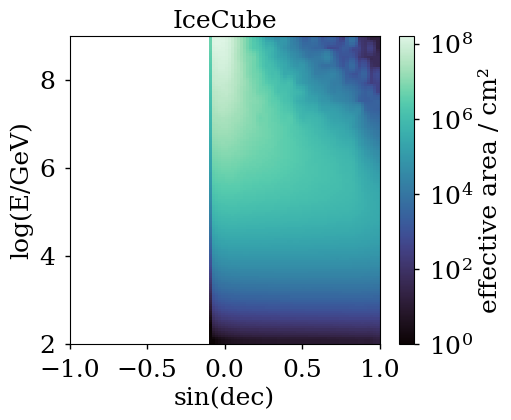

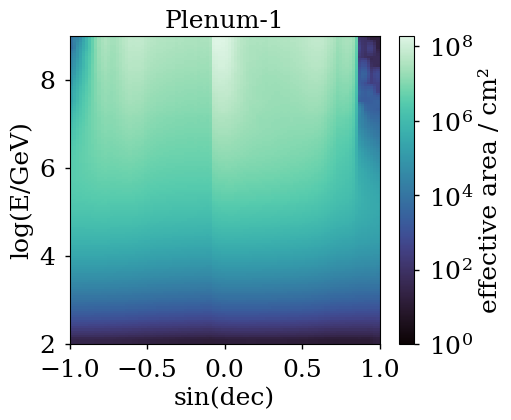

In [7]:
# plot the effective area
for key in ["IceCube", "Plenum-1"]:
    plot_mephistogram(aeff_2d[key], norm=LogNorm(vmin=1))
    cb = plt.gca().collections[0].colorbar
    cb.set_label("effective area / cm²")
    plt.title(key)


# Background

Elementary arithmetic possible.
True


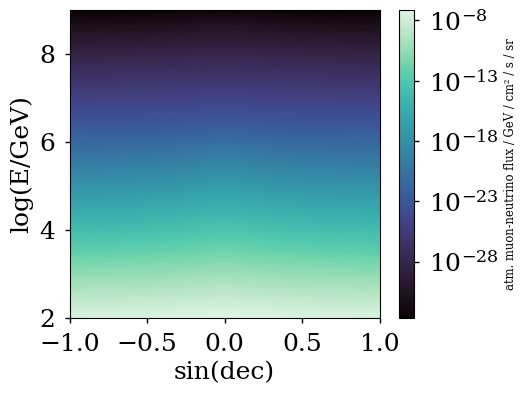

In [8]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histograms are matching, i.e. have the same binning
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))


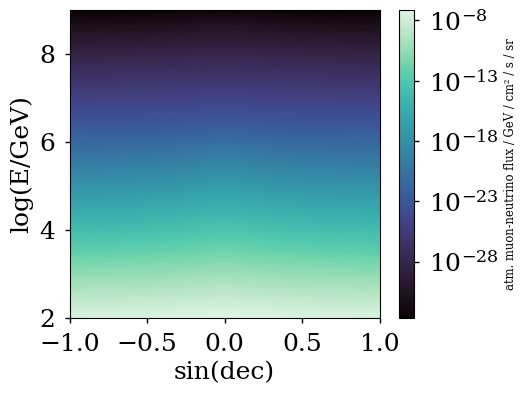

In [19]:

# visualization of bckg flux
plot_mephistogram(bckg_histo["IceCube"], norm=LogNorm())
cb = plt.gca().collections[0].colorbar
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")


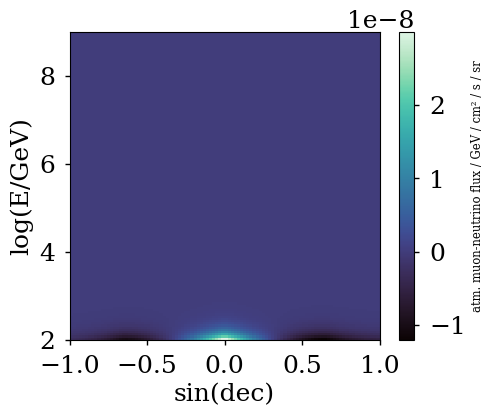

In [20]:

# visualization of bckg flux
plot_mephistogram(bckg_histo["IceCube"]-bckg_histo["P-ONE"])#, norm=LogNorm())
cb = plt.gca().collections[0].colorbar
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")


# Energy smearing

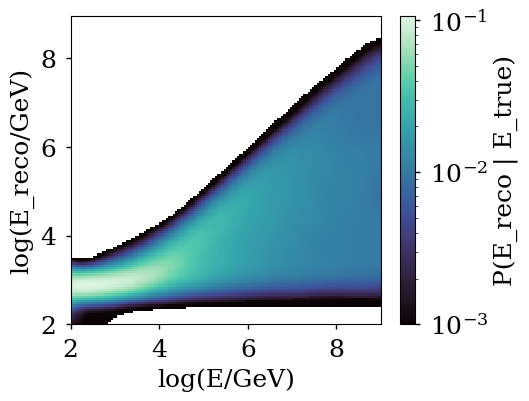

In [9]:
# energy smearing matrix
with open(join(LOCALPATH, "energy_smearing_GP_up.pckl"), "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)

plot_mephistogram(baseline_eres, norm=LogNorm(vmin=1E-3))
cb = plt.gca().collections[0].colorbar
cb.set_label("P(E_reco | E_true)")


# Source flux definition
$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [10]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")


# Config

In [11]:
# generic diffuse flux config
diffuse_config = dict(
    sindec_mids=sindec_mids,
    sindec_width=sindec_width,
    livetime=LIVETIME,
    ewidth=ewidth,
    diff_or_ps="diff",
)


### Full nominal (=Asimov) histograms in  sin(dec) - log(E)

Fit parameters for analysis:
* Global normalization of the atmospheric neutrino flux (background), $N_B$
* Global normalization of the astrophysical neutrino flux (signal), $N_S$
* Spectral index, GAMMA_ASTRO, of the astrophysical neutrino flux (signal), $\gamma$

In [28]:
for key in ["P-ONE", "IceCube"]:
    print(key)
    aeff_factor = calc_aeff_factor(aeff_2d[key], **diffuse_config)

    # asimov data
    # in reconstructed energy
    k_b = atmo_background(aeff_factor, bckg_histo[key], baseline_eres)
    k_s = astro_flux(
        aeff_factor,
        emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=diffuse_flux,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))
    print("S+B", np.sum(k_i))
    print()

P-ONE
Asimov data sum:
Background: 639023.317612387
Signal: 2649.8554035189545
S+B 641673.1730159061

IceCube
Asimov data sum:
Background: 638055.7703141004
Signal: 2649.7004444189274
S+B 640705.4707585194



## Plotting of the event distributions

Text(0.5, 1.0, 'Signal astrophysical flux')

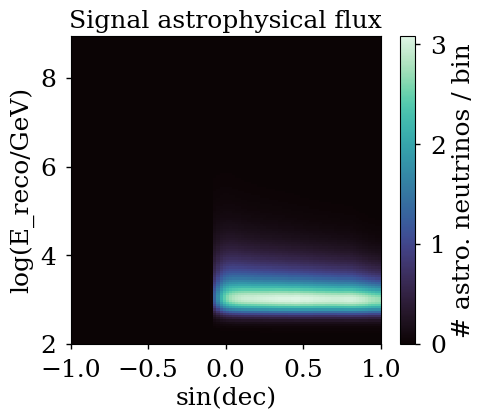

In [29]:
## signal
k_s.plot()
cb = plt.gca().collections[0].colorbar
cb.set_label("# astro. neutrinos / bin")
plt.title("Signal astrophysical flux")


Text(0.5, 1.0, 'Background atmospheric flux')

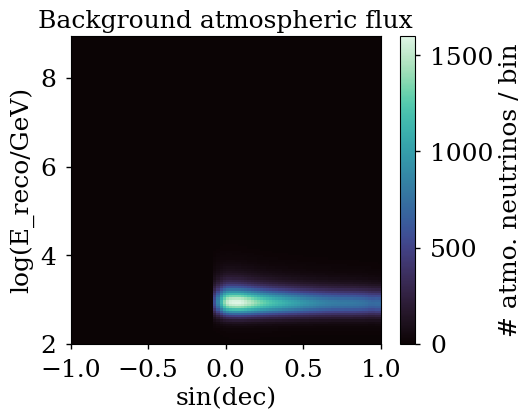

In [30]:
## atmo. background
k_b.plot()
cb = plt.gca().collections[0].colorbar
cb.set_label("# atmo. neutrinos / bin")
plt.title("Background atmospheric flux")


Text(0.5, 1.0, 'Combined S+B neutrino flux')

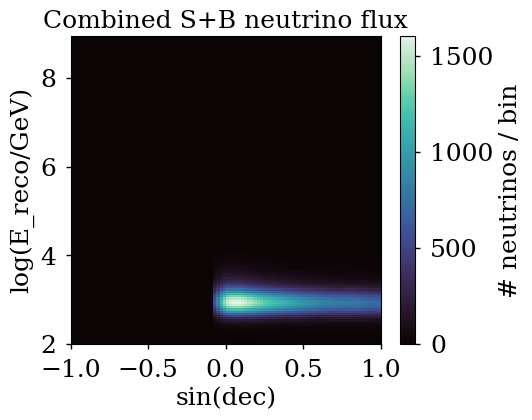

In [31]:
## atmo. background + astro. signal
k_i.plot()
cb = plt.gca().collections[0].colorbar
cb.set_label("# neutrinos / bin")
plt.title("Combined S+B neutrino flux")


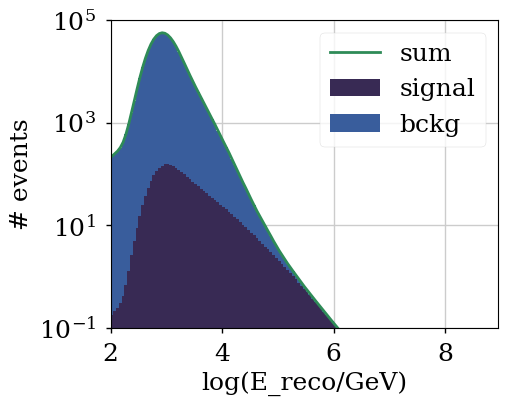

In [32]:
# summed 1D hist in log(E_reco)
f, axes = plt.subplots(figsize=(5, 4))
plot_multiple_mephistograms(
    (k_s.sum(axis=0, return_mephisto=True), k_b.sum(axis=0, return_mephisto=True)),
    labels=["signal", "bckg"],
    f=f,
    axes=axes,
)
k_i_en = k_i.sum(axis=0, return_mephisto=True)
plt.plot(k_i_en.bin_mids, k_i_en.histo, label="sum", color="seagreen")

plt.yscale("log")
plt.ylim(1e-1, 1e5)
plt.ylabel("# events")
plt.legend()


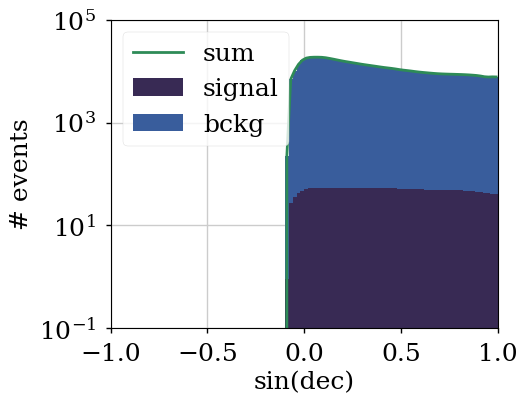

In [33]:
# summed 1D hist in sin(dec)
f, axes = plt.subplots(figsize=(5, 4))
plot_multiple_mephistograms(
    (k_s.sum(axis=1, return_mephisto=True), k_b.sum(axis=1, return_mephisto=True)),
    labels=["signal", "bckg"],
    f=f,
    axes=axes,
)
k_i_en = k_i.sum(axis=1, return_mephisto=True)
plt.plot(k_i_en.bin_mids, k_i_en.histo, label="sum", color="seagreen")

plt.yscale("log")
plt.ylim(1e-1, 1e5)
plt.ylabel("# events")
plt.legend()


### DEMO: Significance test Background vs. Background + Signal

$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma \})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know
For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
$-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
            - \mu_i
            - 0.5 \cdot \log(2 \pi \cdot k_i)
            + k_i
            - k_i \cdot \log(k_i))$

In [ ]:
def llh_single(
    x,
    aeff_factor_s,
    aeff_factor_b,
    bckg_histo,
    baseline_eres,
    k_i,
):
    """
    Define the Log-Likelihood function depending
    on the model parameters (=fit parameters)

    Fit parameters:
    ---------------
    (= x) for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    Other parameters:
    -----------------
    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy
    """

    mu_b = atmo_background(
        aeff_factor=aeff_factor_b,
        bckg_vals=bckg_histo * x[0],
        energy_resolution=baseline_eres,
    )
    mu_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=x[1],
        flux_shape=PL_flux(
            PHI_ASTRO, *x[2:], E_NORM, "powerlaw"
        ),  # here we generate a flux tuple with the current parameters
    )
    return poisson_llh(mu_b + mu_s, k_i)


def llh_multi(
    x, all_aeff_factor_s, all_aeff_factor_b, all_bckg_histo, all_baseline_eres, all_k_i
):
    llh = 0
    for i, aeffs in enumerate(all_aeff_factor_s):
        llh += llh_single(
            aeffs, all_aeff_factor_b[i], all_bckg_histo[i], baseline_eres[i], all_k_i[i]
        )
    return llh


The significance of the hypothesis test is evaluated using the test statistic

$TS = -2 \log ( H_0(\mu = {\rm best fit}) / H_1(\mu = {\rm best fit}) )$

where the best-fit parameters are obtained with an optimization function `fmin_l_bfgs_b`.


The data (k) is modeled as 'Asimov data', the TS calculation fulfills the requirements of Wilks' theorem, and thus we know that the underlying TS distribution
follows a $\chi ^2$ distribution, here with 2 degrees of freedom.

The p-value of the Asimov data set represents the expected significance of an analysis with real data if it has the same model parameters. It's the integral of the $\chi ^2$ distribution from TS to infinity (`chi.sf(TS)`). The p-value in terms of Gaussian standard deviations can be calculated via the inverse error function (`erfinv`).

In [ ]:
aeff_factor = calc_aeff_factor(aeff_2d["IceCube"], **diffuse_config)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_histo, baseline_eres)
k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))
print("S+B", np.sum(k_i))

# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: llh_single((x[0], 0, 2), aeff_factor, aeff_factor, k_i)
# background + signal, 3 free parameters
global_llh = lambda x: llh_single(x, aeff_factor, aeff_factor, k_i)
# ... and fit both hypotheses!
# background first
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])
# .. then signal+background
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

## Note: out_bckg/comp[1] contains the value of the
# LLH function with the optimized model parameters
# out_bckg[1] - out_comp[1] == -2log(L(H_0) / L(H_1)) = TS (see above)

# calculate p-value and significance with Wilks' theorem and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
# ... we do quite well without accounting for systematic uncertainties :D

Asimov data sum:
Background: 634420.7621554744
Signal: 2682.276523458852
S+B 637103.0386789333
Bckg-only normalization: [1.00422791]
Signal fit parameters: [0.99999986 1.00000444 2.3700051 ]
P-VALUE: 2.861993357086476e-21 SIGNIFICANCE: inf
